# Colorbot - training your own model


![img](imgs/colorbot_model.png)
![img](imgs/colorbot_execution.png)


## Dependencies

In [1]:
# Tensorflow
import tensorflow as tf
print('Tested with TensorFLow 1.2.0')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Tested with TensorFLow 1.2.0
Your TensorFlow version: 1.2.0


## Parameters

In [2]:
# Data files
TRAIN_INPUT = 'path/to/train/'
TEST_INPUT = 'path/to/test/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
BATCH_SIZE = 64

# Parameters for data processing
CHARACTERS = [chr(i) for i in range(256)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'
RGB_KEY = 'rgb'

## Helper functions

In [3]:
# This function creates a sparse tensor in the following way, given:
# indices = [[0, 0], [1, 1], [2, 2]]
# values = [1, 2, 3]
# dense_shape = [3, 4]
#
# The output will be a sparse tensor that represents this dense tensor:
# [ 
#   [1, 0, 0, 0]
#   [0, 2, 0, 0]
#   [0, 0, 3, 0]
# ]
#
# We're using this to generate a Sparse tensor that can be easily
# formated in a one hot representation.
# More at: https://www.tensorflow.org/api_docs/python/tf/SparseTensor
def _sparse_string_to_index(sp, mapping):
    # This operation constructs a lookup table to convert tensor of strings
    # into int64 IDs
    table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
    
    return tf.SparseTensor(indices=sp.indices,
                           values=table.lookup(sp.values),
                           dense_shape=sp.dense_shape)

# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plot a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Input functions

In [4]:
# Input function used for training and testing                                                
def get_input_fn(csv_file, batch_size, epochs=1):
   
    # loading csv in memory
    df = pd.read_csv(csv_file)
    df = df.dropna()
    
    # Sequence length is used by the Dynamic RNN
    # to dynamically unroll the graph :D!
    df['sequence_length'] = df.name.str.len().astype(np.int32)

    # We can use a canned input function for generating batches
    # with the pandas data frame, then we call it and
    # make the changes needed on the features
    pd_fn = tf.estimator.inputs.pandas_input_fn(df, shuffle=True,
                                                batch_size=batch_size,
                                                num_epochs=epochs,
                                                queue_capacity=100000)
    
    def input_fn():   
        # calling the pandas input function
        fields = argparse.Namespace(**pd_fn())
        
        # Split strings into chars
        split_color_name = tf.string_split(fields.name, delimiter='')
        # Creating a tf constant to hold the map char -> index
        # this is need to create the sparse tensor and after the one hot encode
        table = tf.contrib.lookup.index_table_from_tensor(CHARACTERS, dtype=tf.string)
        # Names represented in a sparse tensor
        integerized_color_name = table.lookup(split_color_name)
        
        # Tensor of normalized RGB values
        rgb = tf.to_float(tf.stack([fields.red, fields.green, fields.blue], axis=1)) / 255.0

        features = {COLOR_NAME_KEY: integerized_color_name, SEQUENCE_LENGTH_KEY: fields.sequence_length}
        return features, rgb

    return input_fn

In [5]:
# Creating my own input function for a custom CSV file
# it's simpler than the input_fn above but just used for small tests
def my_test_input_fn():
    df = pd.read_csv(MY_TEST_INPUT)
    df = df.dropna()
    df['sequence_length'] = df.name.str.len().astype(np.int32)

    color_name = df.name.tolist()

    split_color_name = tf.string_split(color_name, delimiter='')
    mapping = tf.constant(CHARACTERS, name="mapping")
    integerized_color_name = _sparse_string_to_index(split_color_name, mapping)

    x = {COLOR_NAME_KEY: integerized_color_name, SEQUENCE_LENGTH_KEY: df.sequence_length.tolist()}

    y = np.asarray([[0, 0, 0]], dtype=np.float32)

    return x, y

In [6]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

## Creating the Estimator model in the gif_model dir

In [7]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = features[SEQUENCE_LENGTH_KEY]

        # Creating dense representation for the names
        # and then converting it to one hot representation
        dense_color_name = tf.sparse_tensor_to_dense(color_name, default_value=len(CHARACTERS))
        color_name_onehot = tf.one_hot(dense_color_name, depth=len(CHARACTERS) + 1)
        
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.contrib.rnn.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        loss = None
        train_op = None

        if mode != tf.contrib.learn.ModeKeys.INFER:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.contrib.learn.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

In [8]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', #changing optimizer to Adam
                        learning_rate=0.01)

### !!!! Atention !!!!
### notice the model_dir path
estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='gif_model',
                                   config=tf.contrib.learn.RunConfig(keep_checkpoint_max=None,
                                   save_checkpoints_steps=100))

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_environment': 'local', '_model_dir': 'gif_model', '_keep_checkpoint_every_n_hours': 10000, '_task_type': None, '_num_worker_replicas': 0, '_tf_random_seed': None, '_is_chief': True, '_num_ps_replicas': 0, '_save_checkpoints_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_keep_checkpoint_max': None, '_master': '', '_session_config': None, '_save_summary_steps': 100, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4680911550>, '_task_id': 0}


## Trainning and Evaluating [OPTIONAL]

We could use a [experiment](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Experiment) instead.


In [10]:
NUM_EPOCHS = 12
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from gif_model/model.ckpt-214
INFO:tensorflow:Saving checkpoints for 215 into gif_model/model.ckpt.
INFO:tensorflow:gif_model/model.ckpt-215 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:loss = 0.0561563, step = 215
INFO:tensorflow:Saving checkpoints for 315 into gif_model/model.ckpt.
INFO:tensorflow:gif_model/model.ckpt-315 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:global_step/sec: 3.01971
INFO:tensorflow:loss = 0.0652968, step = 315 (33.118 sec)
INFO:tensorflow:Saving checkpoints for 415 into gif_model/model.ckpt.
INFO:tensorflow:gif_model/model.ckpt-415 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:global_step/sec: 3.06843
INFO:tensorflow:loss = 0.0577213, step = 415 (32.589 sec)
INFO:tensorflow:Saving checkpoints for 428 into gif_model/model.ckpt.
INFO:tensorflow:gif_model/model.ckpt-428 is not in all_model_checkpoi

## Generating predictions for each checkpoint

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/1', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 0: gif_model/1
--------------------
INFO:tensorflow:Restoring parameters from gif_model/1/model.ckpt-1
orange rgb (111, 116, 86) #6f7456


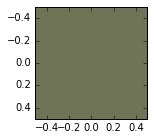

tensorflow orange rgb (333, 338, 258) #14d152102


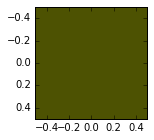

adfgasdgasd rgb (165, 169, 139) #a5a98b


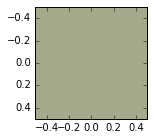

purple blue rgb (241, 246, 198) #f1f6c6


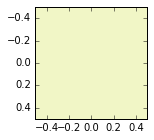

purple red rgb (226, 230, 177) #e2e6b1


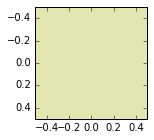

purple rgb (111, 115, 87) #6f7357


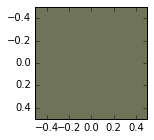

blue rgb (69, 72, 58) #45483a


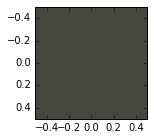

red rgb (59, 61, 41) #3b3d29


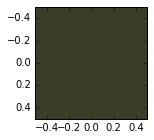

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/101', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 1: gif_model/101
--------------------
INFO:tensorflow:Restoring parameters from gif_model/101/model.ckpt-101
orange rgb (145, 132, 89) #918459


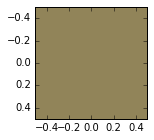

tensorflow orange rgb (160, 144, 101) #a09065


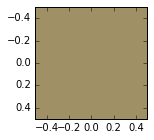

adfgasdgasd rgb (143, 135, 81) #8f8751


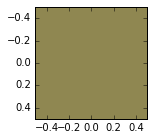

purple blue rgb (74, 128, 182) #4a80b6


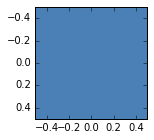

purple red rgb (134, 118, 87) #867657


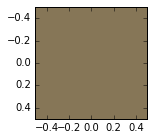

purple rgb (123, 113, 114) #7b7172


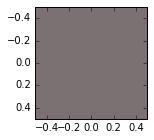

blue rgb (78, 115, 150) #4e7396


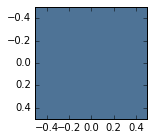

red rgb (133, 109, 63) #856d3f


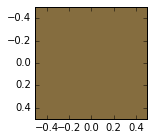

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/201', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 2: gif_model/201
--------------------
INFO:tensorflow:Restoring parameters from gif_model/201/model.ckpt-201
orange rgb (186, 157, 110) #ba9d6e


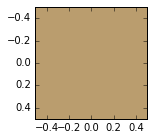

tensorflow orange rgb (212, 175, 127) #d4af7f


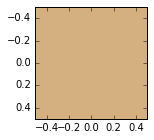

adfgasdgasd rgb (176, 167, 124) #b0a77c


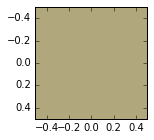

purple blue rgb (127, 150, 192) #7f96c0


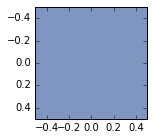

purple red rgb (151, 111, 95) #976f5f


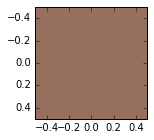

purple rgb (164, 133, 140) #a4858c


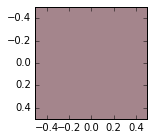

blue rgb (112, 139, 159) #708b9f


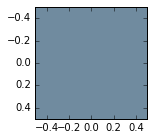

red rgb (139, 91, 70) #8b5b46


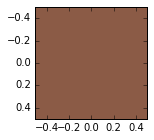

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/315', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 3: gif_model/315
--------------------
INFO:tensorflow:Restoring parameters from gif_model/315/model.ckpt-315
orange rgb (196, 133, 95) #c4855f


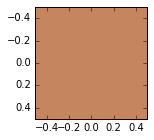

tensorflow orange rgb (201, 148, 122) #c9947a


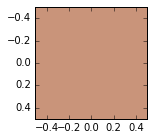

adfgasdgasd rgb (172, 161, 131) #aca183


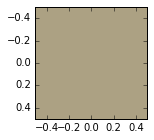

purple blue rgb (56, 135, 182) #3887b6


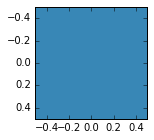

purple red rgb (149, 39, 67) #952743


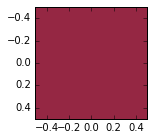

purple rgb (139, 107, 130) #8b6b82


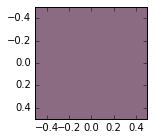

blue rgb (73, 131, 158) #49839e


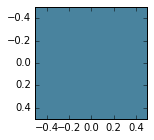

red rgb (151, 55, 65) #973741


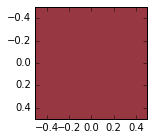

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/415', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 4: gif_model/415
--------------------
INFO:tensorflow:Restoring parameters from gif_model/415/model.ckpt-415
orange rgb (194, 138, 72) #c28a48


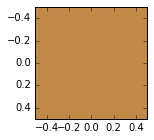

tensorflow orange rgb (201, 161, 115) #c9a173


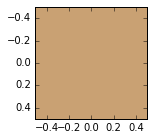

adfgasdgasd rgb (180, 164, 124) #b4a47c


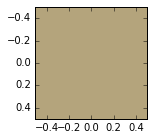

purple blue rgb (90, 122, 195) #5a7ac3


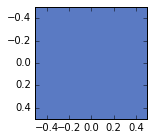

purple red rgb (229, -12, 16) #e5-c10


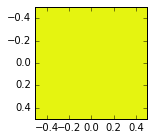

purple rgb (141, 79, 121) #8d4f79


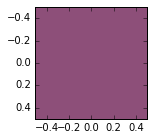

blue rgb (82, 122, 169) #527aa9


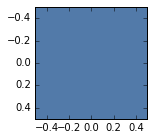

red rgb (203, 19, 19) #cb1313


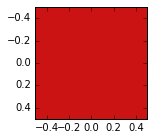

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/529', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 5: gif_model/529
--------------------
INFO:tensorflow:Restoring parameters from gif_model/529/model.ckpt-529
orange rgb (199, 134, 59) #c7863b


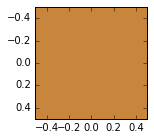

tensorflow orange rgb (200, 145, 99) #c89163


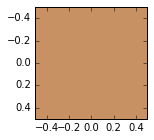

adfgasdgasd rgb (171, 167, 147) #aba793


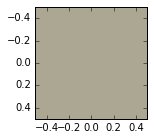

purple blue rgb (136, 154, 208) #889ad0


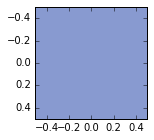

purple red rgb (168, 19, 44) #a8132c


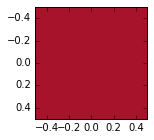

purple rgb (149, 82, 136) #955288


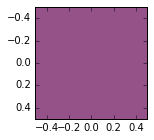

blue rgb (127, 147, 179) #7f93b3


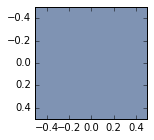

red rgb (152, 45, 42) #982d2a


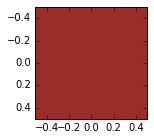

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/629', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 6: gif_model/629
--------------------
INFO:tensorflow:Restoring parameters from gif_model/629/model.ckpt-629
orange rgb (220, 132, 41) #dc8429


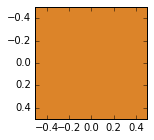

tensorflow orange rgb (224, 157, 80) #e09d50


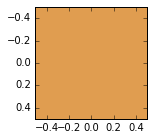

adfgasdgasd rgb (167, 177, 145) #a7b191


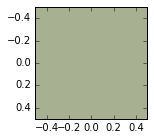

purple blue rgb (89, 103, 157) #59679d


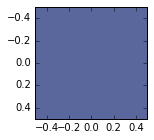

purple red rgb (163, 51, 74) #a3334a


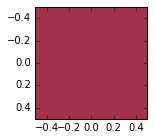

purple rgb (118, 63, 108) #763f6c


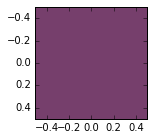

blue rgb (90, 124, 151) #5a7c97


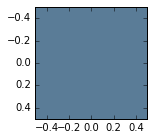

red rgb (167, 71, 58) #a7473a


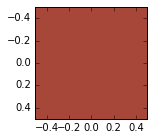

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/743', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 7: gif_model/743
--------------------
INFO:tensorflow:Restoring parameters from gif_model/743/model.ckpt-743
orange rgb (212, 104, 20) #d46814


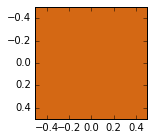

tensorflow orange rgb (195, 98, 35) #c36223


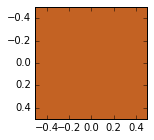

adfgasdgasd rgb (151, 148, 120) #979478


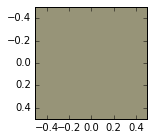

purple blue rgb (81, 108, 190) #516cbe


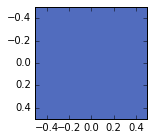

purple red rgb (124, 69, 97) #7c4561


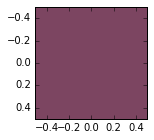

purple rgb (112, 69, 133) #704585


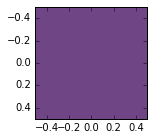

blue rgb (81, 121, 165) #5179a5


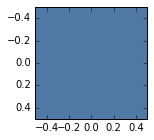

red rgb (151, 64, 42) #97402a


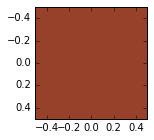

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/843', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 8: gif_model/843
--------------------
INFO:tensorflow:Restoring parameters from gif_model/843/model.ckpt-843
orange rgb (176, 108, 59) #b06c3b


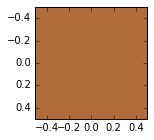

tensorflow orange rgb (189, 121, 78) #bd794e


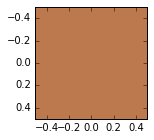

adfgasdgasd rgb (159, 155, 132) #9f9b84


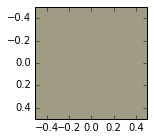

purple blue rgb (94, 125, 186) #5e7dba


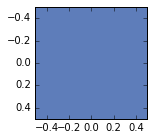

purple red rgb (117, 67, 70) #754346


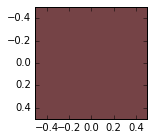

purple rgb (148, 89, 156) #94599c


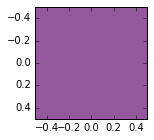

blue rgb (83, 134, 177) #5386b1


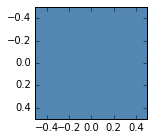

red rgb (119, 57, 42) #77392a


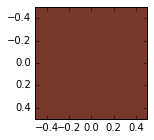

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/957', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 9: gif_model/957
--------------------
INFO:tensorflow:Restoring parameters from gif_model/957/model.ckpt-957
orange rgb (195, 112, 57) #c37039


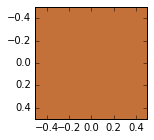

tensorflow orange rgb (190, 128, 95) #be805f


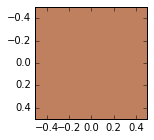

adfgasdgasd rgb (164, 152, 136) #a49888


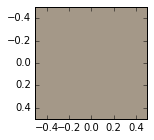

purple blue rgb (88, 81, 171) #5851ab


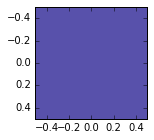

purple red rgb (136, 84, 146) #885492


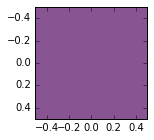

purple rgb (127, 64, 168) #7f40a8


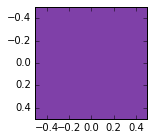

blue rgb (62, 121, 170) #3e79aa


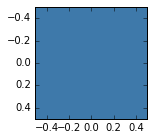

red rgb (162, 48, 64) #a23040


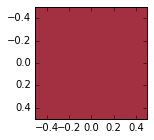

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/1285', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 10: gif_model/1285
--------------------
INFO:tensorflow:Restoring parameters from gif_model/1285/model.ckpt-1285
orange rgb (216, 103, 38) #d86726


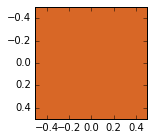

tensorflow orange rgb (221, 135, 79) #dd874f


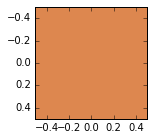

adfgasdgasd rgb (152, 152, 134) #989886


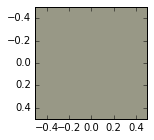

purple blue rgb (81, 107, 170) #516baa


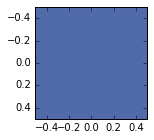

purple red rgb (127, 66, 82) #7f4252


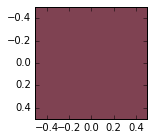

purple rgb (128, 76, 140) #804c8c


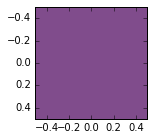

blue rgb (71, 126, 175) #477eaf


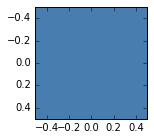

red rgb (151, 39, 44) #97272c


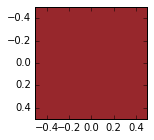

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/1485', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 11: gif_model/1485
--------------------
INFO:tensorflow:Restoring parameters from gif_model/1485/model.ckpt-1485
orange rgb (233, 118, 30) #e9761e


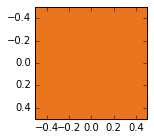

tensorflow orange rgb (229, 137, 54) #e58936


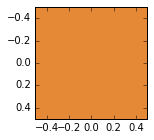

adfgasdgasd rgb (180, 156, 136) #b49c88


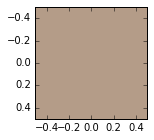

purple blue rgb (101, 116, 184) #6574b8


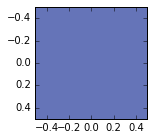

purple red rgb (174, 58, 67) #ae3a43


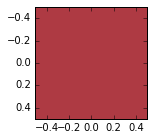

purple rgb (141, 80, 149) #8d5095


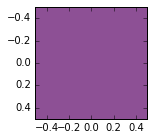

blue rgb (99, 137, 177) #6389b1


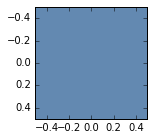

red rgb (194, 35, 39) #c22327


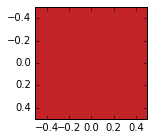

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/1926', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 12: gif_model/1926
--------------------
INFO:tensorflow:Restoring parameters from gif_model/1926/model.ckpt-1926
orange rgb (237, 115, 40) #ed7328


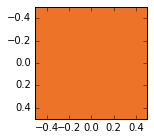

tensorflow orange rgb (243, 146, 65) #f39241


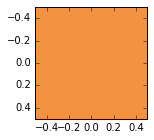

adfgasdgasd rgb (156, 163, 154) #9ca39a


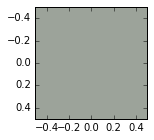

purple blue rgb (80, 78, 276) #504e114


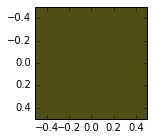

purple red rgb (140, 57, 68) #8c3944


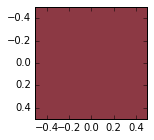

purple rgb (156, 29, 226) #9c1de2


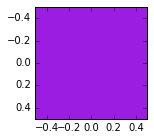

blue rgb (67, 113, 194) #4371c2


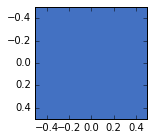

red rgb (193, 3, 9) #c10309


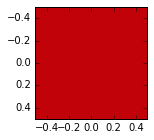

continue (y/n) ? y
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': 'gif_model/2354', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1}
--------------------
GIF MODEL 13: gif_model/2354
--------------------
INFO:tensorflow:Restoring parameters from gif_model/2354/model.ckpt-2354
orange rgb (232, 115, 47) #e8732f


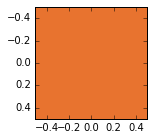

tensorflow orange rgb (230, 140, 81) #e68c51


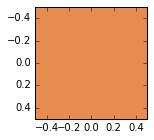

adfgasdgasd rgb (168, 170, 164) #a8aaa4


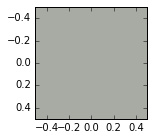

purple blue rgb (45, 23, 202) #2d17ca


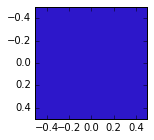

purple red rgb (183, 25, 46) #b7192e


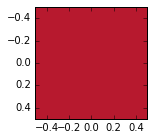

purple rgb (142, 25, 144) #8e1990


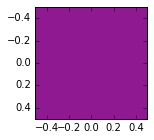

blue rgb (18, 79, 176) #124fb0


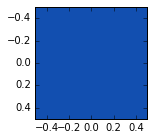

red rgb (200, 13, 25) #c80d19


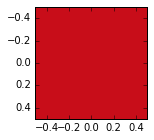

continue (y/n) ? y


In [20]:
gif_model = ['1', '101', '201', '315', '415', '529', '629', '743', '843', '957', '1285', '1485', '1926', '2354']

for i in range(len(gif_model)):
    pre_estimator = tf.estimator.Estimator(model_dir='gif_model/' + gif_model[i], model_fn=model_fn)
    preds = pre_estimator.predict(input_fn=my_test_input_fn)

    color_names = _get_csv_column(MY_TEST_INPUT, 'name')

    print('-' * 20)
    print('GIF MODEL %d: gif_model/%s' % (i, gif_model[i]))
    print('-' * 20)
    for p, name in zip(preds, color_names):
        color = tuple(map(int, p * 255))
        hex_color = '#%02x%02x%02x' % (color)
        print(name, 'rgb', color, hex_color)
        _plot_rgb(p)
    
    c = input('continue (y/n) ? ')
    if c == 'n':
        break
    elif c != 'y':
        print('%s is not valid, but its considered an yes' % c)